<a href="https://colab.research.google.com/github/ayushkgu/2048-CS112/blob/main/Market_Forecasting_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**List of Library Dependencies for my project**

**1.   Libraries installed via pip**


* yfinance

* ta (technical analysis indicators)

* shap (SHAP interpretability)

* pmdarima (ARIMA)

* xgboost

* pytorch-forecasting

* lightning (Lightning PyTorch)

* torchmetrics

* prophet (for univariate forecasting)




**2.  Core Python Libraries**


*  numpy

*  pandas

*  datetime (Python standard library)

**3. Modeling, Deep Learning, and Visualization Libraries**


* scikit-learn (LinearRegression, RandomForestRegressor, mean_absolute_error)
* statsmodels (ARIMA)
* torch (PyTorch)
* pytorch_forecasting (TemporalFusionTransformer, TimeSeriesDataSet, GroupNormalizer, QuantileLoss)
* matplotlib
* seaborn







**Set up Environment**

In [ ]:
!pip -q install yfinance ta shap pmdarima -U


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 12.6 MB/s eta 0:00:00


**Collect data**

In [ ]:
import warnings, numpy as np, pandas as pd
import yfinance as yf
from datetime import datetime
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

# ---- Config ----
TICKER = "AAPL"
MKT = "SPY"           # market context
START = "2016-01-01"
END   = "2025-01-01"
HORIZON = 1           # predict next-day return (T+1)
N_SPLITS = 6          # walk-forward splits


**Download & Basic Prep**

In [ ]:
raw = yf.download([TICKER, MKT], start=START, end=END, auto_adjust=True, progress=False)

# Keep a flat column index
raw.columns = ['_'.join(c).strip() for c in raw.columns.to_flat_index()]

# Basic OHLCV price data (Open, High, Low, Close, Volume)
df = raw.copy()

# Daily returns (close-to-close)
df[f"{TICKER}_ret"] = df[f"Close_{TICKER}"].pct_change()
df[f"{MKT}_ret"]    = df[f"Close_{MKT}"].pct_change()

print(df.head())


            Close_AAPL   Close_SPY  High_AAPL    High_SPY   Low_AAPL  \
Date                                                                   
2016-01-04   23.753157  170.875626  23.757667  170.884121  22.997836   
2016-01-05   23.157911  171.164642  23.865884  171.623660  23.090272   
2016-01-06   22.704721  169.005493  23.081256  170.059538  22.517584   
2016-01-07   21.746475  164.950806  22.576201  167.832450  21.741967   
2016-01-08   21.861467  163.140213  22.346226  166.480888  21.816374   

               Low_SPY  Open_AAPL    Open_SPY  Volume_AAPL  Volume_SPY  \
Date                                                                     
2016-01-04  168.810015  23.135372  170.425104    270597600   222353500   
2016-01-05  170.051088  23.843337  171.198638    223164000   110845800   
2016-01-06  167.968440  22.673156  168.597463    273829600   152112600   
2016-01-07  164.559780  22.249272  166.038859    324377600   213436100   
2016-01-08  162.851202  22.219964  165.919857    28

**Feature Engineering (past-only)**

In [ ]:
# Indicators for AAPL
rsi = RSIIndicator(df[f"Close_{TICKER}"], window=14).rsi()
macd = MACD(df[f"Close_{TICKER}"]).macd()
sma_5  = df[f"Close_{TICKER}"].rolling(5).mean()
sma_20 = df[f"Close_{TICKER}"].rolling(20).mean()
sma_50 = df[f"Close_{TICKER}"].rolling(50).mean()

# Market context features from SPY
mkt_sma_20 = df[f"Close_{MKT}"].rolling(20).mean()
mkt_rsi    = RSIIndicator(df[f"Close_{MKT}"], window=14).rsi()

# Assemble feature frame
feat = pd.DataFrame(index=df.index)
feat["rsi"] = rsi
feat["macd"] = macd
feat["sma_5"] = sma_5
feat["sma_20"] = sma_20
feat["sma_50"] = sma_50
feat["ret_1"] = df[f"{TICKER}_ret"]                      # yesterday's return
feat["mkt_ret_1"] = df[f"{MKT}_ret"]                    # market return (t-1)
feat["mkt_sma_20"] = mkt_sma_20
feat["mkt_rsi"] = mkt_rsi

# Lag ALL features by 0 relative to prediction day (they already use info up to 'today').
# Target is next-day return, so we shift target by -HORIZON. No future info leaks into features.
target = df[f"{TICKER}_ret"].shift(-HORIZON).rename("y")

# Final modeling table
data = pd.concat([feat, target], axis=1).dropna()
data.head()


,rsi,macd,sma_5,sma_20,sma_50,ret_1,mkt_ret_1,mkt_sma_20,mkt_rsi,y
Date,,,,,,,,,,
2016-03-15,67.553492,0.361981,23.197432,22.542177,22.187637,0.020094,-0.001629,167.633545,64.687436,0.013291
2016-03-16,70.474014,0.419683,23.417324,22.631154,22.193026,0.013291,0.005787,168.078116,66.766996,-0.001604
2016-03-17,69.648287,0.457035,23.627240,22.739286,22.209549,-0.001604,0.006344,168.611095,68.939138,0.001134
2016-03-18,69.916288,0.483261,23.793180,22.851273,22.235679,0.001134,0.003930,169.182079,70.244624,-0.000095
2016-03-21,69.860778,0.498120,23.946878,22.953624,22.280930,-0.000095,0.001419,169.647288,70.724832,0.007648


**Function to build the same feature table for ANY ticker**

In [ ]:
def build_dataset(
    ticker,
    mkt="SPY",
    start=START,
    end=END,
    horizon=HORIZON,
):
    import yfinance as yf
    from ta.momentum import RSIIndicator
    from ta.trend import MACD

    # 1) Download prices
    raw = yf.download([ticker, mkt], start=start, end=end,
                      auto_adjust=True, progress=False)
    raw.columns = ['_'.join(c).strip() for c in raw.columns.to_flat_index()]
    df = raw.copy()

    # 2) returns
    df[f"{ticker}_ret"] = df[f"Close_{ticker}"].pct_change()
    df[f"{mkt}_ret"]    = df[f"Close_{mkt}"].pct_change()

    # 3) Indicators (same as before)
    rsi     = RSIIndicator(df[f"Close_{ticker}"], window=14).rsi()
    macd    = MACD(df[f"Close_{ticker}"]).macd()
    sma_5   = df[f"Close_{ticker}"].rolling(5).mean()
    sma_20  = df[f"Close_{ticker}"].rolling(20).mean()
    sma_50  = df[f"Close_{ticker}"].rolling(50).mean()


    # SPY context
    mkt_sma_20 = df[f"Close_{mkt}"].rolling(20).mean()
    mkt_rsi    = RSIIndicator(df[f"Close_{mkt}"], window=14).rsi()

    # feature table
    feat = pd.DataFrame(index=df.index)
    feat["rsi"]        = rsi
    feat["macd"]       = macd
    feat["sma_5"]      = sma_5
    feat["sma_20"]     = sma_20
    feat["sma_50"]     = sma_50
    feat["ret_1"]      = df[f"{ticker}_ret"]
    feat["mkt_ret_1"]  = df[f"{mkt}_ret"]
    feat["mkt_sma_20"] = mkt_sma_20
    feat["mkt_rsi"]    = mkt_rsi

    # target: next-day return
    target = df[f"{ticker}_ret"].shift(-horizon).rename("y")

    # clean + align
    data = pd.concat([feat, target], axis=1)
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    X = data.drop(columns=["y"])
    y = data["y"]

    return data, X, y

**Testing it with AAPL, MSFT, NVDA**

In [ ]:
data_test, X_test, y_test = build_dataset("AAPL")
data_test.head()


,rsi,macd,sma_5,sma_20,sma_50,ret_1,mkt_ret_1,mkt_sma_20,mkt_rsi,y
Date,,,,,,,,,,
2016-03-15,67.553492,0.361981,23.197432,22.542177,22.187637,0.020094,-0.001629,167.633545,64.687436,0.013291
2016-03-16,70.474014,0.419683,23.417324,22.631154,22.193026,0.013291,0.005787,168.078116,66.766996,-0.001604
2016-03-17,69.648287,0.457035,23.627240,22.739286,22.209549,-0.001604,0.006344,168.611095,68.939138,0.001134
2016-03-18,69.916288,0.483261,23.793180,22.851273,22.235679,0.001134,0.003930,169.182079,70.244624,-0.000095
2016-03-21,69.860778,0.498120,23.946878,22.953624,22.280930,-0.000095,0.001419,169.647288,70.724832,0.007648


**Helper: Walk-Forward Evaluation**

In [ ]:
def walk_forward_splits(n, n_splits=5, min_train_size=252):
    """
    Expanding-window walk-forward indices.
    Ensures each train has at least ~1 trading year (252 days).
    """
    indices = np.arange(n)
    split_points = np.linspace(min_train_size, n - 1, n_splits + 1, dtype=int)[1:]
    for sp in split_points:
        train_idx = indices[:sp]
        test_idx = np.array([sp])
        # Instead of single-day test, can use a rolling block (e.g., next 21 days).
        test_block = indices[sp:min(sp + 21, n)]
        yield train_idx, test_block

def directional_accuracy(y_true, y_pred):
    """
    Fraction of times the predicted sign matches the true sign.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan

    return (np.sign(y_true[mask]) == np.sign(y_pred[mask])).mean()


def evaluate_model(X, y, model, n_splits=5):
    maes, dirs = [], []
    for tr, te in walk_forward_splits(len(X), n_splits=n_splits):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        maes.append(mean_absolute_error(y_te, pred))
        dirs.append(directional_accuracy(y_te, pred))
    return float(np.mean(maes)), float(np.mean(dirs))

def evaluate_naive_baseline(X, y):
    """
    Naïve 'random walk' for returns: predict 0 next day (i.e., no move).
    """
    maes, dirs = [], []
    for _, te in walk_forward_splits(len(X), n_splits=N_SPLITS):
        y_te = y.iloc[te]
        pred = np.zeros_like(y_te.values, dtype=float)
        maes.append(mean_absolute_error(y_te, pred))
        dirs.append(directional_accuracy(y_te, pred))
    return float(np.mean(maes)), float(np.mean(dirs))


**Train/Eval: Linear Regression vs Naïve**

In [ ]:
# Features & target
X = data.drop(columns=["y"])
y = data["y"]

# Remove any infinite or missing values from the feature set
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

# Evaluate Naïve
naive_mae, naive_dir = evaluate_naive_baseline(X, y)

# Evaluate Linear Regression
lr = LinearRegression()
lr_mae, lr_dir = evaluate_model(X, y, lr, n_splits=N_SPLITS)

print("=== Walk-Forward Results (AAPL, T+1 return) ===")
print(f"Naïve (predict 0)   -> MAE: {naive_mae:.6f} | Directional Acc: {naive_dir:.2%}")
print(f"Linear Regression   -> MAE: {lr_mae:.6f} | Directional Acc: {lr_dir:.2%}")


=== Walk-Forward Results (AAPL, T+1 return) ===
Naïve (predict 0)   -> MAE: 0.011341 | Directional Acc: 0.00%
Linear Regression   -> MAE: 0.012188 | Directional Acc: 40.48%


**Install XGBoost**

In [ ]:
!pip -q install xgboost -U


**Extra imports, seed, and model factory**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def make_models():
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=2,
            n_jobs=-1,
            random_state=RANDOM_STATE,
        ),
        "XGBoost": XGBRegressor(
            n_estimators=500,
            max_depth=3,
            learning_rate=0.03,
            subsample=0.9,
            colsample_bytree=0.8,
            reg_lambda=1.5,
            reg_alpha=0.5,
            random_state=RANDOM_STATE,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
        ),
    }
    return models


**Stronger naïve baseline + run all models**

In [ ]:
def evaluate_naive_persistence(X, y):
    maes, dirs = [], []
    for tr, te in walk_forward_splits(len(X), n_splits=N_SPLITS):
        y_te = y.iloc[te]
        pred = y.shift(1).iloc[te].values  # 1-step lag prediction
        mask = ~np.isnan(pred)
        maes.append(mean_absolute_error(y_te[mask], pred[mask]))
        dirs.append((np.sign(y_te[mask]) == np.sign(pred[mask])).mean())
    return float(np.mean(maes)), float(np.mean(dirs))

results = []

# 1) Naïve baselines
naive0_mae, naive0_dir = evaluate_naive_baseline(X, y)     # predict 0
pers_mae, pers_dir     = evaluate_naive_persistence(X, y)  # predict previous return

results.append({"Model": "NaiveZero(returns=0)", "MAE": naive0_mae, "DirectionalAcc": naive0_dir})
results.append({"Model": "NaivePersistence(y[t-1])", "MAE": pers_mae, "DirectionalAcc": pers_dir})

# 2) Learned models
for name, model in make_models().items():
    mae, dacc = evaluate_model(X, y, model, n_splits=N_SPLITS)
    results.append({"Model": name, "MAE": mae, "DirectionalAcc": dacc})

results_df = pd.DataFrame(results).sort_values(["MAE", "DirectionalAcc"], ascending=[True, False]).reset_index(drop=True)
results_df


,Model,MAE,DirectionalAcc
0,XGBoost,0.011296,0.476190
1,NaiveZero(returns=0),0.011341,0.000000
2,LinearRegression,0.012188,0.404762
3,RandomForest,0.015039,0.555556
4,NaivePersistence(y[t-1]),0.015501,0.547619


**Evaluate all models for given ticker**

In [ ]:
def evaluate_all_models_for_ticker(ticker, mkt="SPY"):
    """
    Build features for a given ticker and run:
    - NaiveZero baseline
    - Persistence baseline
    - LinearRegression, RandomForest, XGBoost

    Returns DataFrame with Model, MAE, DirectionalAcc for that ticker.
    """

    data, X, y = build_dataset(ticker, mkt=mkt)

    # clean just in case
    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index]

    results = []

    # 1) Naive baselines
    naive0_mae, naive0_dir = evaluate_naive_baseline(X, y)
    pers_mae,  pers_dir    = evaluate_naive_persistence(X, y)

    results.append({
        "Ticker": ticker,
        "Model": "NaiveZero(returns=0)",
        "MAE": naive0_mae,
        "DirectionalAcc": naive0_dir,
    })
    results.append({
        "Ticker": ticker,
        "Model": "NaivePersistence(y[t-1])",
        "MAE": pers_mae,
        "DirectionalAcc": pers_dir,
    })

    # 2) Learned models (LR, RF, XGB)
    for name, model in make_models().items():
        mae, dacc = evaluate_model(X, y, model, n_splits=N_SPLITS)
        results.append({
            "Ticker": ticker,
            "Model": name,
            "MAE": mae,
            "DirectionalAcc": dacc,
        })

    return pd.DataFrame(results)


**Testing it on AAPL**

In [ ]:
results_aapl = evaluate_all_models_for_ticker("AAPL")
results_aapl


,Ticker,Model,MAE,DirectionalAcc
0,AAPL,NaiveZero(returns=0),0.011341,0.000000
1,AAPL,NaivePersistence(y[t-1]),0.015501,0.547619
2,AAPL,LinearRegression,0.012188,0.404762
3,AAPL,RandomForest,0.015039,0.555556
4,AAPL,XGBoost,0.011296,0.476190


**ARIMA evaluator function**

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

def evaluate_arima_univariate(y, n_splits=N_SPLITS):
    """
    Univariate ARIMA baseline using ARIMA(1,0,0).
    """
    y = pd.Series(y).astype(float)

    maes, dirs = [], []

    for tr, te in walk_forward_splits(len(y), n_splits=n_splits):
        y_train = y.iloc[tr]
        y_test  = y.iloc[te]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            try:
                model = ARIMA(y_train, order=(1, 0, 0)).fit()
                preds = model.forecast(steps=len(y_test))
            except Exception:
                preds = np.zeros_like(y_test)

        maes.append(mean_absolute_error(y_test, preds))
        dirs.append(directional_accuracy(y_test, preds))

    return float(np.mean(maes)), float(np.mean(dirs))


In [ ]:
_, X_tmp, y_tmp = build_dataset("AAPL")
mae_arima, dir_arima = evaluate_arima_univariate(y_tmp)

print("ARIMA AAPL MAE:", mae_arima)
print("ARIMA AAPL DirectionalAcc:", dir_arima)


ARIMA AAPL MAE: 0.011664653181289111
ARIMA AAPL DirectionalAcc: 0.4682539682539682


**Helper that runs ARIMA + all ML models for a ticker**

In [ ]:
def evaluate_all_models_with_arima_for_ticker(ticker, mkt="SPY"):
    """
    Run ARIMA + naive baselines + ML models for a given ticker.
    Returns a DataFrame with Model, MAE, DirectionalAcc.
    """
    # Build features and target
    data, X, y = build_dataset(ticker, mkt=mkt)

    X = X.replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index]

    results = []

    # 0) ARIMA baseline (univariate on y only)
    arima_mae, arima_dir = evaluate_arima_univariate(y, n_splits=N_SPLITS)
    results.append({
        "Ticker": ticker,
        "Model": "ARIMA(1,0,0)",
        "MAE": arima_mae,
        "DirectionalAcc": arima_dir,
    })

    # 1) Naive baselines
    naive0_mae, naive0_dir = evaluate_naive_baseline(X, y)
    pers_mae,  pers_dir    = evaluate_naive_persistence(X, y)

    results.append({
        "Ticker": ticker,
        "Model": "NaiveZero(returns=0)",
        "MAE": naive0_mae,
        "DirectionalAcc": naive0_dir,
    })
    results.append({
        "Ticker": ticker,
        "Model": "NaivePersistence(y[t-1])",
        "MAE": pers_mae,
        "DirectionalAcc": pers_dir,
    })

    # 2) Learned models (LR, RF, XGB)
    for name, model in make_models().items():
        mae, dacc = evaluate_model(X, y, model, n_splits=N_SPLITS)
        results.append({
            "Ticker": ticker,
            "Model": name,
            "MAE": mae,
            "DirectionalAcc": dacc,
        })

    return pd.DataFrame(results)


In [ ]:
tickers = ["AAPL", "MSFT", "NVDA", "QQQ"]

all_results_with_arima = pd.concat(
    [evaluate_all_models_with_arima_for_ticker(t) for t in tickers],
    ignore_index=True
)

display(all_results_with_arima)

all_results_with_arima.to_csv(
    "walkforward_results_with_arima_multi_ticker.csv",
    index=False
)
print("Saved walkforward_results_with_arima_multi_ticker.csv")


,Ticker,Model,MAE,DirectionalAcc
0,AAPL,"ARIMA(1,0,0)",0.011665,0.468254
1,AAPL,NaiveZero(returns=0),0.011341,0.000000
2,AAPL,NaivePersistence(y[t-1]),0.015501,0.547619
3,AAPL,LinearRegression,0.012188,0.404762
4,AAPL,RandomForest,0.015039,0.555556
5,AAPL,XGBoost,0.011296,0.476190
6,MSFT,"ARIMA(1,0,0)",0.011411,0.484127
7,MSFT,NaiveZero(returns=0),0.010981,0.000000
8,MSFT,NaivePersistence(y[t-1]),0.014800,0.563492
9,MSFT,LinearRegression,0.011060,0.500000


Saved walkforward_results_with_arima_multi_ticker.csv


**Visualize Results**

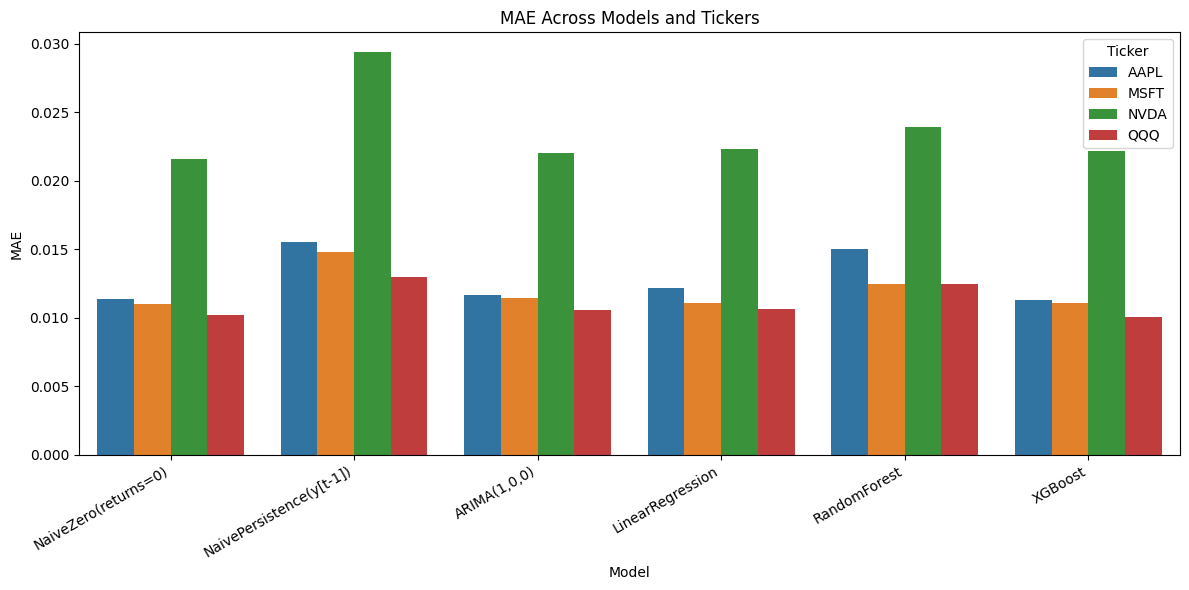

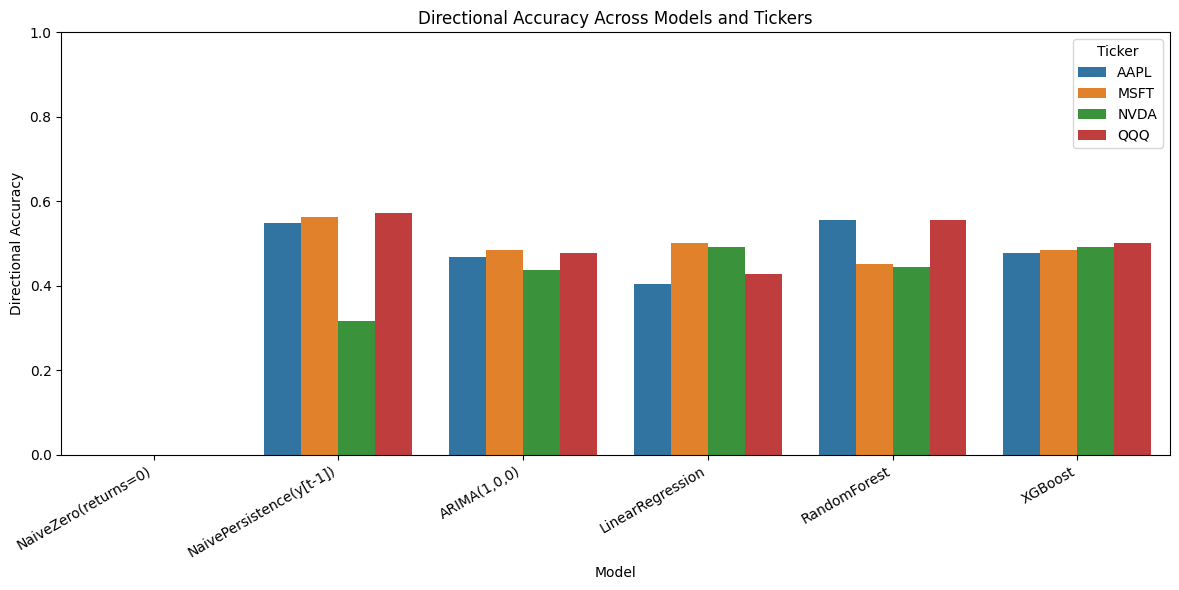

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = all_results_with_arima.copy()

model_order = ["NaiveZero(returns=0)",
               "NaivePersistence(y[t-1])",
               "ARIMA(1,0,0)",
               "LinearRegression",
               "RandomForest",
               "XGBoost"]

df["Model"] = pd.Categorical(df["Model"], categories=model_order, ordered=True)

# 1) MAE across models and tickers
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="Model", y="MAE", hue="Ticker")
plt.title("MAE Across Models and Tickers")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 2) Directional Accuracy across models and tickers
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="Model", y="DirectionalAcc", hue="Ticker")
plt.title("Directional Accuracy Across Models and Tickers")
plt.xlabel("Model")
plt.ylabel("Directional Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


**Add SHAP interpretability for XGBoost**

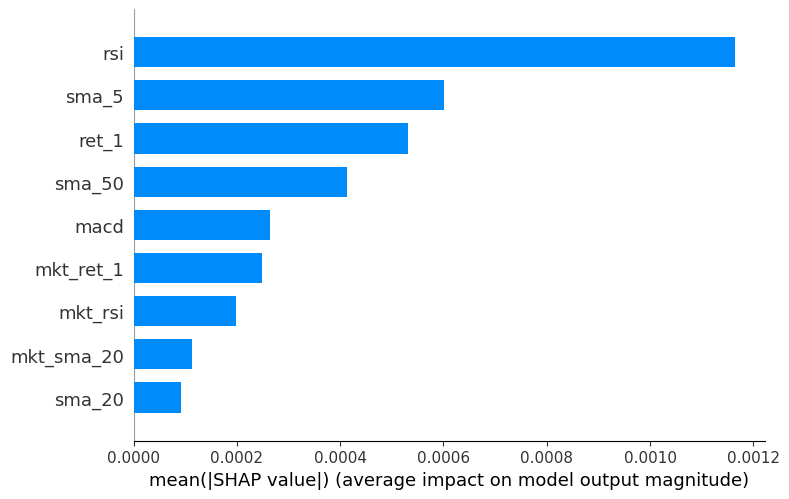

In [ ]:
import shap

# rebuild AAPL dataset
data_aapl, X_aapl, y_aapl = build_dataset("AAPL")
X_aapl = X_aapl.replace([np.inf, -np.inf], np.nan).dropna()
y_aapl = y_aapl.loc[X_aapl.index]

# get the last walk-forward split
splits = list(walk_forward_splits(len(X_aapl), n_splits=N_SPLITS))
tr, te = splits[-1]

X_tr, X_te = X_aapl.iloc[tr], X_aapl.iloc[te]
y_tr, y_te = y_aapl.iloc[tr], y_aapl.iloc[te]

# train xgboost
xgb = make_models()["XGBoost"]
xgb.fit(X_tr, y_tr)

# SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_te)

shap.summary_plot(shap_values, X_te, plot_type="bar")  # bar chart


**Volatility regime analysis for XGBoost (AAPL, MSFT, NVDA)**

In [ ]:
def regime_analysis_for_ticker(ticker):
    """
    Computes directional accuracy in calm vs. volatile regimes
    across ALL walk-forward splits for a given ticker.
    """
    # build data
    data, X, y = build_dataset(ticker)

    # rolling volatility on returns
    vol_20 = X["ret_1"].rolling(20).std()
    vol_threshold = vol_20.median()

    splits = list(walk_forward_splits(len(X), n_splits=N_SPLITS))
    fold_results = []

    for tr, te in splits:
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        # model = XGBoost
        model = make_models()["XGBoost"]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)

        regimes = np.where(vol_20.loc[X_te.index] > vol_threshold,
                           "volatile", "calm")

        fold_df = pd.DataFrame({
            "ticker": ticker,
            "true": y_te.values,
            "pred": preds,
            "regime": regimes
        })
        fold_df["correct"] = (np.sign(fold_df["true"]) == np.sign(fold_df["pred"]))
        fold_results.append(fold_df)

    result_df = pd.concat(fold_results, ignore_index=True)
    regime_accuracy = result_df.groupby("regime")["correct"].mean()

    return regime_accuracy, result_df


In [ ]:
tickers = ["AAPL", "MSFT", "NVDA"]

regime_results = {}
regime_details = {}

for t in tickers:
    acc, df_details = regime_analysis_for_ticker(t)
    regime_results[t] = acc
    regime_details[t] = df_details
    print(f"{t} regime accuracy:\n{acc}\n")


AAPL regime accuracy:
regime
calm        0.620000
volatile    0.517857
Name: correct, dtype: float64

MSFT regime accuracy:
regime
calm        0.569231
volatile    0.585366
Name: correct, dtype: float64

NVDA regime accuracy:
regime
calm        0.579710
volatile    0.594595
Name: correct, dtype: float64



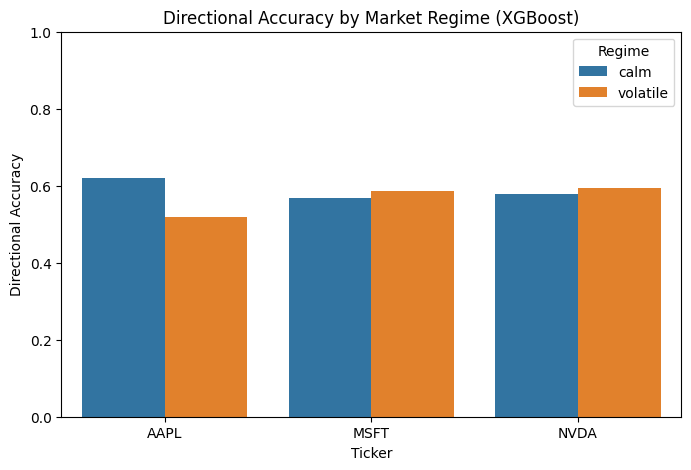

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rows = []
for t in tickers:
    acc = regime_results[t]
    for regime, value in acc.items():
        rows.append([t, regime, value])

plot_df = pd.DataFrame(rows, columns=["Ticker", "Regime", "Accuracy"])

plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="Ticker", y="Accuracy", hue="Regime")
plt.title("Directional Accuracy by Market Regime (XGBoost)")
plt.ylabel("Directional Accuracy")
plt.ylim(0,1)
plt.show()


**Add PROPHET baseline for ETFs (SPY + QQQ)**

In [ ]:
pip install prophet


In [ ]:
from prophet import Prophet


In [ ]:
def evaluate_prophet_univariate(y, n_splits=N_SPLITS):
    """
    Univariate Prophet baseline using only the return series.
    Uses the same walk-forward splits as other models.
    """
    y = pd.Series(y)
    maes, dirs = [], []

    for tr, te in walk_forward_splits(len(y), n_splits=n_splits):
        y_train = y.iloc[tr]
        y_test  = y.iloc[te]

        train_df = pd.DataFrame({
            "ds": y_train.index,
            "y": y_train.values
        })

        test_df = pd.DataFrame({
            "ds": y_test.index
        })

        m = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
        )
        m.fit(train_df)

        forecast = m.predict(test_df)
        preds = forecast["yhat"].values

        maes.append(mean_absolute_error(y_test, preds))
        dirs.append(directional_accuracy(y_test, preds))

    return float(np.mean(maes)), float(np.mean(dirs))


In [ ]:
prophet_rows = []

tickers_all = ["AAPL", "MSFT", "NVDA", "QQQ"]

for t in tickers_all:
    _, _, y_t = build_dataset(t)
    mae_p, dir_p = evaluate_prophet_univariate(y_t)
    prophet_rows.append({
        "Ticker": t,
        "Model": "Prophet",
        "MAE": mae_p,
        "DirectionalAcc": dir_p,
    })
    print(f"{t} Prophet -> MAE={mae_p:.5f}, DirAcc={dir_p:.3f}")

prophet_results = pd.DataFrame(prophet_rows)
prophet_results


AAPL Prophet -> MAE=0.01251, DirAcc=0.341
MSFT Prophet -> MAE=0.01063, DirAcc=0.635
NVDA Prophet -> MAE=0.02288, DirAcc=0.413
QQQ Prophet -> MAE=0.01087, DirAcc=0.397


,Ticker,Model,MAE,DirectionalAcc
0,AAPL,Prophet,0.012508,0.341270
1,MSFT,Prophet,0.010633,0.634921
2,NVDA,Prophet,0.022884,0.412698
3,QQQ,Prophet,0.010866,0.396825


In [ ]:
all_results_full = pd.concat(
    [all_results_with_arima, prophet_results],
    ignore_index=True
)

display(all_results_full)

all_results_full.to_csv(
    "walkforward_results_with_arima_prophet_multi_ticker.csv",
    index=False
)
print("Saved walkforward_results_with_arima_prophet_multi_ticker.csv")


,Ticker,Model,MAE,DirectionalAcc
0,AAPL,"ARIMA(1,0,0)",0.011665,0.468254
1,AAPL,NaiveZero(returns=0),0.011341,0.000000
2,AAPL,NaivePersistence(y[t-1]),0.015501,0.547619
3,AAPL,LinearRegression,0.012188,0.404762
4,AAPL,RandomForest,0.015039,0.555556
5,AAPL,XGBoost,0.011296,0.476190
6,MSFT,"ARIMA(1,0,0)",0.011411,0.484127
7,MSFT,NaiveZero(returns=0),0.010981,0.000000
8,MSFT,NaivePersistence(y[t-1]),0.014800,0.563492
9,MSFT,LinearRegression,0.011060,0.500000


Saved walkforward_results_with_arima_prophet_multi_ticker.csv


**---------------------------------------------------All Relevant Figures Below**---------------------------------------------------


**MAE & Directional Accuracy across models and tickers**

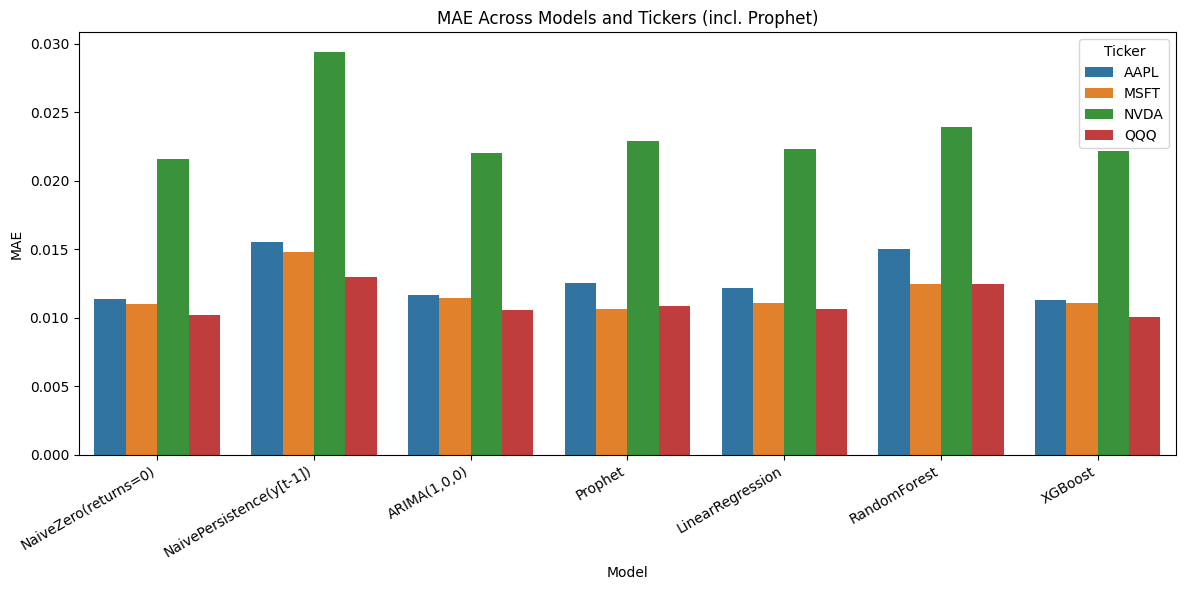

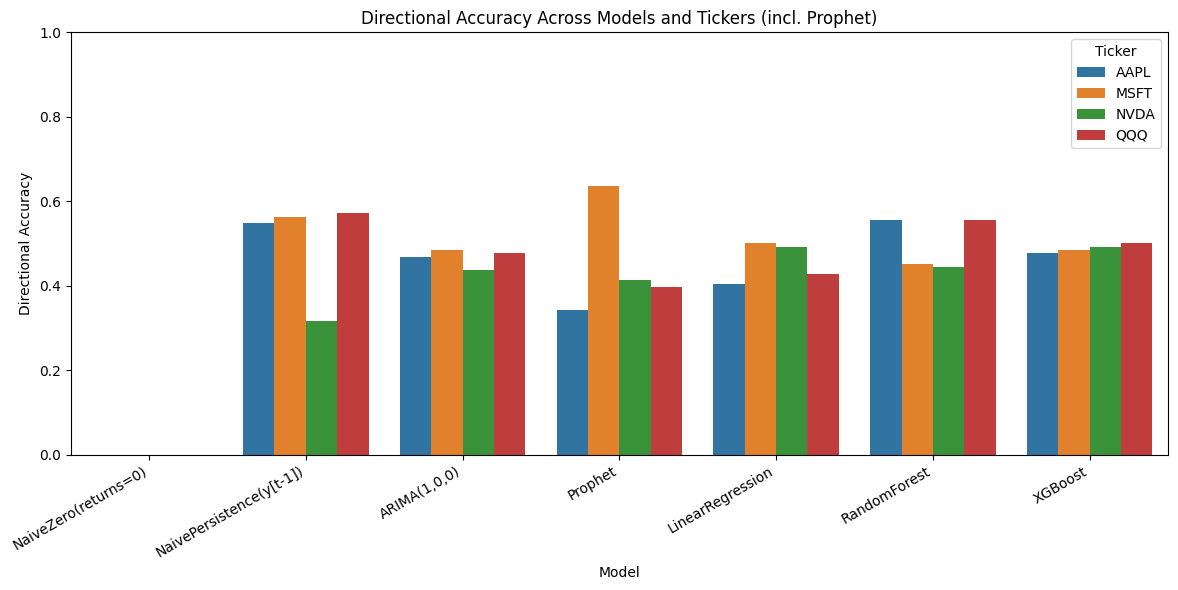

In [ ]:
df = all_results_full.copy()

model_order = [
    "NaiveZero(returns=0)",
    "NaivePersistence(y[t-1])",
    "ARIMA(1,0,0)",
    "Prophet",
    "LinearRegression",
    "RandomForest",
    "XGBoost",
]

df["Model"] = pd.Categorical(df["Model"], categories=model_order, ordered=True)

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="Model", y="MAE", hue="Ticker")
plt.title("MAE Across Models and Tickers (incl. Prophet)")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="Model", y="DirectionalAcc", hue="Ticker")
plt.title("Directional Accuracy Across Models and Tickers (incl. Prophet)")
plt.xlabel("Model")
plt.ylabel("Directional Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


**“Best model per ticker” tables**

In [ ]:
# Best (lowest) MAE per ticker
best_mae = df.loc[df.groupby("Ticker")["MAE"].idxmin(), ["Ticker", "Model", "MAE"]]
print("Best MAE per ticker:")
display(best_mae)

# Best (highest) directional accuracy per ticker
best_dir = df.loc[df.groupby("Ticker")["DirectionalAcc"].idxmax(), ["Ticker", "Model", "DirectionalAcc"]]
print("Best Directional Accuracy per ticker:")
display(best_dir)


best_mae.to_csv("table_best_mae_per_ticker.csv", index=False)
best_dir.to_csv("table_best_dir_per_ticker.csv", index=False)


Best MAE per ticker:


,Ticker,Model,MAE
5,AAPL,XGBoost,0.011282
25,MSFT,Prophet,0.010647
13,NVDA,NaiveZero(returns=0),0.021562
23,QQQ,XGBoost,0.010066


Best Directional Accuracy per ticker:


,Ticker,Model,DirectionalAcc
4,AAPL,RandomForest,0.555556
25,MSFT,Prophet,0.626984
17,NVDA,XGBoost,0.492063
20,QQQ,NaivePersistence(y[t-1]),0.571429


**SHAP interpretability Bar Plot for XGBoost**

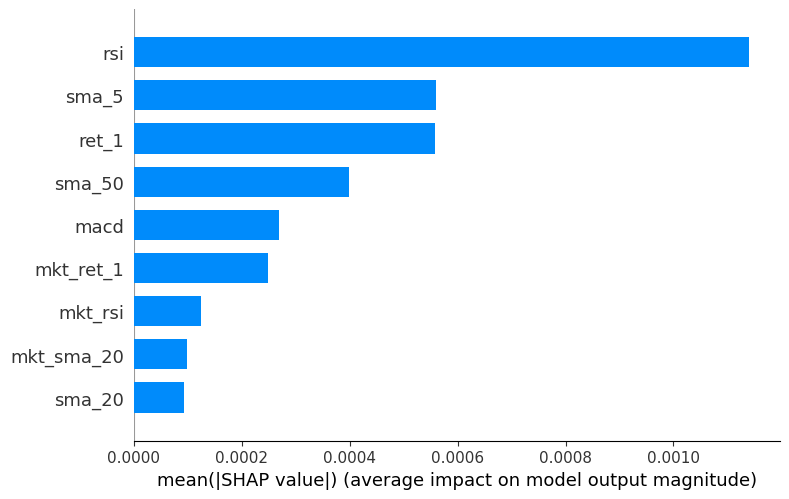

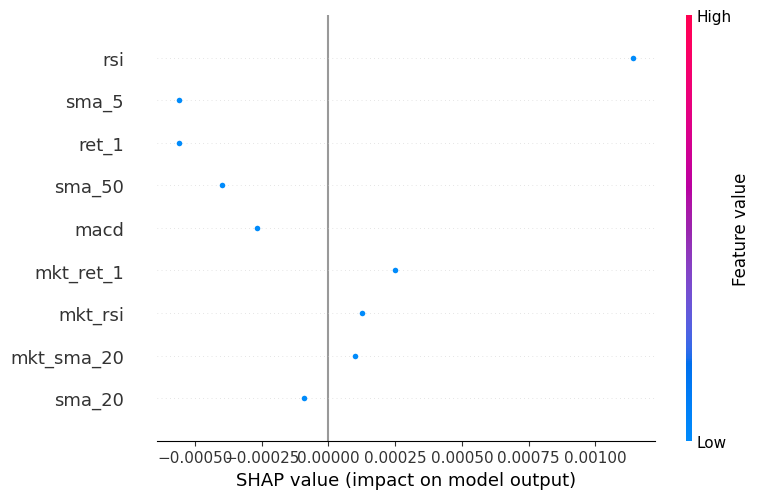

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP bar plot
shap.summary_plot(shap_values, X_te, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("fig_shap_bar_aapl_xgboost.png", dpi=300)
plt.show()



**Install TFT dependencies**

In [ ]:
!pip install -q pytorch-forecasting lightning torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 42.2 MB/s eta 0:00:00


In [ ]:
import torch
import lightning.pytorch as pl

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss


**Build a TFT-ready dataset (AAPL, multi-horizon**

In [ ]:
import numpy as np
import pandas as pd

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

# Using existing helper to get AAPL features + target
data_aapl, X_aapl, y_aapl = build_dataset("AAPL")

data_tft = data_aapl.copy()
data_tft = data_tft.reset_index().rename(columns={"Date": "date"})

data_tft["time_idx"] = np.arange(len(data_tft))
data_tft["ticker"]   = "AAPL"

# Simple calendar features
data_tft["day_of_week"] = data_tft["date"].dt.weekday.astype("int64")
data_tft["month"]       = data_tft["date"].dt.month.astype("int64")

data_tft["ticker"] = data_tft["ticker"].astype(str)

# Real-valued covariates
real_features = [
    "rsi", "macd", "sma_5", "sma_20", "sma_50",
    "ret_1", "mkt_ret_1", "mkt_sma_20", "mkt_rsi",
]

MAX_ENCODER_LENGTH     = 60  # how many past days the model sees
MAX_PREDICTION_LENGTH  = 5   # how many future days we predict

# Chronological split between training and validation
validation_fraction = 0.2
cutoff_idx = int(len(data_tft) * (1 - validation_fraction))

training_df   = data_tft.iloc[:cutoff_idx].copy()
validation_df = data_tft.iloc[cutoff_idx:].copy()

# TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    training_df,
    time_idx="time_idx",
    target="y",                   #  next-day return
    group_ids=["ticker"],

    # encoder/decoder lengths
    min_encoder_length=MAX_ENCODER_LENGTH // 2,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=MAX_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,

    # static features (one per series)
    static_categoricals=["ticker"],
    static_reals=[],

    # time-varying known features (available into the future)
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx", "day_of_week", "month"],

    # time-varying unknown features (only known up to "now")
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=real_features,

    # normalize target per ticker
    target_normalizer=GroupNormalizer(groups=["ticker"]),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    validation_df,
    stop_randomization=True,
)

# Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = training.to_dataloader(
    train=True, batch_size=BATCH_SIZE, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=BATCH_SIZE, num_workers=0
)


**Define + train the TFT**

In [ ]:
import numpy as np

pl.seed_everything(42)

# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="min",
)

lr_logger = LearningRateMonitor()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="tft-aapl-{epoch:02d}-{val_loss:.4f}",
)

logger = TensorBoardLogger("tft_logs", name="aapl_tft")

# Trainer using Lightning API
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
    logger=logger,
)

# Build TFT from dataset (multi-horizon)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),      # multi-quantile loss
    output_size=7,            # 7 quantiles (0.1 ... 0.9)
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"# TFT parameters: {tft.size():,}")

# Train
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Load best checkpoint (lowest val_loss)
best_tft = tft



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


# TFT parameters: 93,980


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      1 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    512 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │  5.8 K │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 27.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │  7.8 K │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 94.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 462                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

**Evaluate TFT (MAE + directional accuracy, multi-horizon)**

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def directional_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    nonzero = y_true != 0
    if nonzero.sum() == 0:
        return np.nan
    return (np.sign(y_true[nonzero]) == np.sign(y_pred[nonzero])).mean()

# Get raw forecasts + inputs + targets
preds = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    return_y=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

# Quantile predictions from TFT
pred_all = preds.output["prediction"]

# True targets
y_true_tensor = preds.y[0] if isinstance(preds.y, (list, tuple)) else preds.y

# Pick median quantile
median_idx = len(best_tft.loss.quantiles) // 2

y_pred = (
    pred_all[..., median_idx]
    .detach()
    .cpu()
    .numpy()
    .reshape(-1)
)
y_true = (
    y_true_tensor
    .detach()
    .cpu()
    .numpy()
    .reshape(-1)
)

tft_mae = mean_absolute_error(y_true, y_pred)
tft_dir = directional_accuracy(y_true, y_pred)

print(f"TFT (AAPL, horizon={MAX_PREDICTION_LENGTH}) -> MAE: {tft_mae:.6f} | Directional Acc: {tft_dir:.2%}")


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


TFT (AAPL, horizon=5) -> MAE: 0.010293 | Directional Acc: 45.15%


**Attention-based interpretability**

Global variable importance

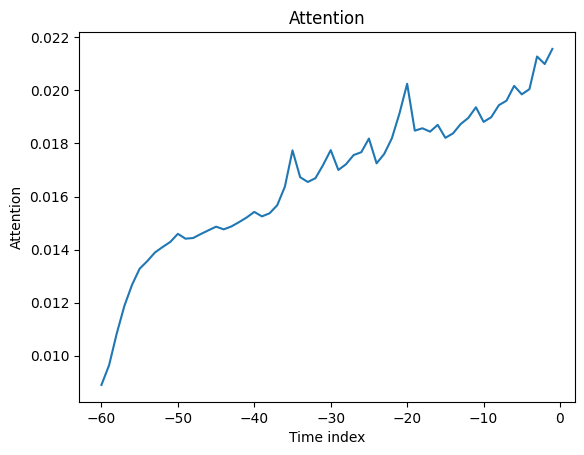

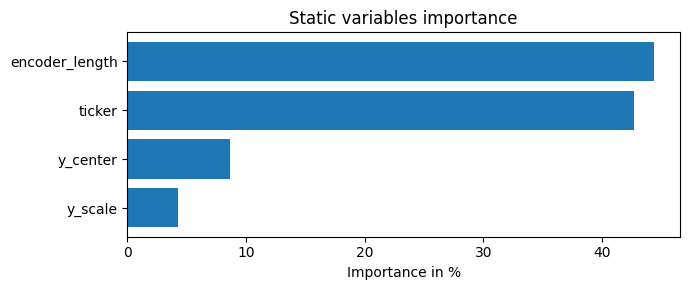

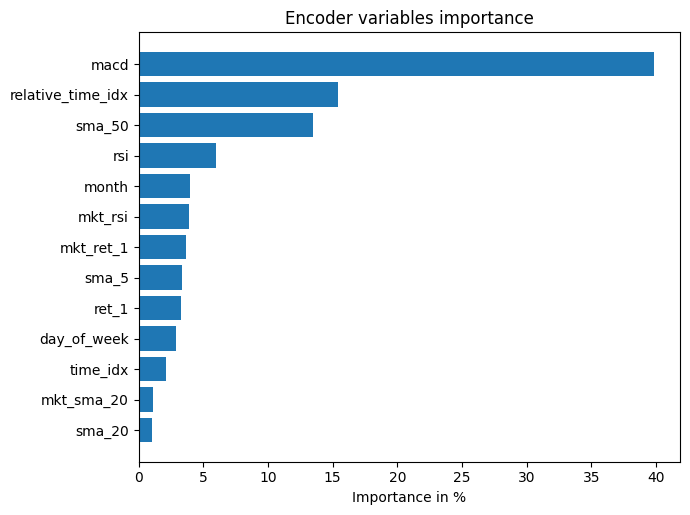

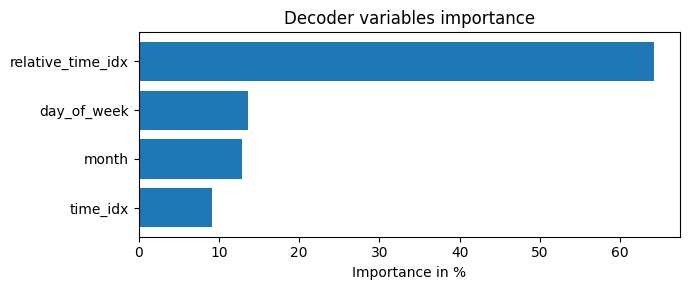

Saved: tft_attention_importance.png
Saved: tft_static_variables_importance.png
Saved: tft_encoder_variables_importance.png
Saved: tft_decoder_variables_importance.png


In [ ]:
import matplotlib.pyplot as plt

# Compute interpretation
interpretation = best_tft.interpret_output(
    preds.output,
    reduction="sum",
)

fig_dict = best_tft.plot_interpretation(interpretation)

for name, fig in fig_dict.items():
    plt.show(fig)

    filename = f"tft_{name}_importance.png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print("Saved:", filename)

    plt.close(fig)


A few example windows with attention

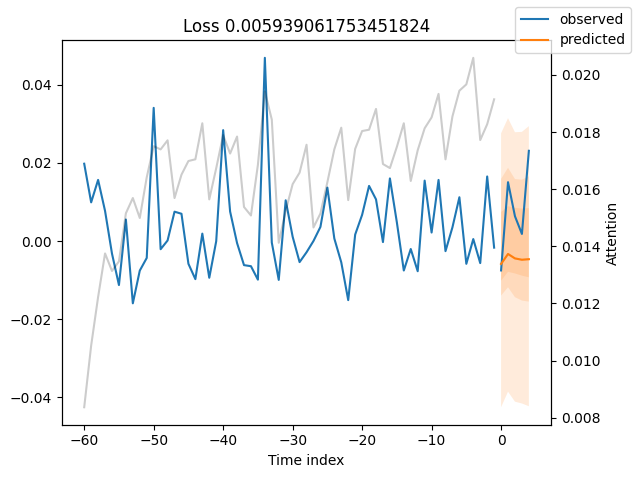

Saved: tft_attention_window_1.png


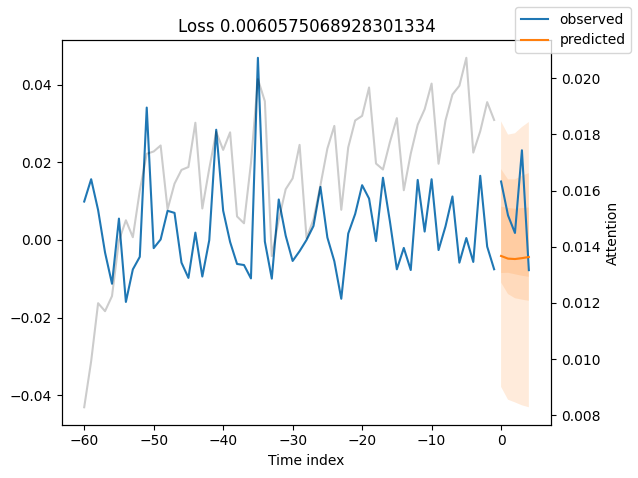

Saved: tft_attention_window_2.png


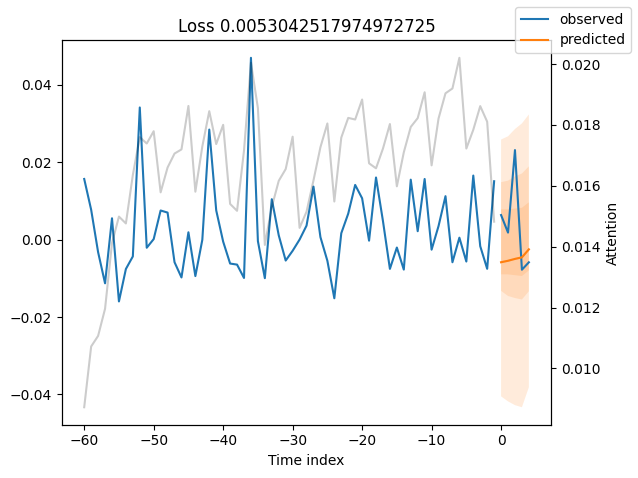

Saved: tft_attention_window_3.png


In [ ]:
N_WINDOWS = 3

for idx in range(N_WINDOWS):
    fig = best_tft.plot_prediction(
        preds.x,
        preds.output,
        idx=idx,
        add_loss_to_title=True,
    )
    plt.show()
    fname = f"tft_attention_window_{idx+1}.png"
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", fname)



In [ ]:
import nbformat as nbf

in_path = "ML_Principles_Honors_Contract_Project.ipynb"
out_path = "ML_Principles_Honors_Contract_Project_clean.ipynb"

nb = nbf.read(in_path, as_version=4)

# Drop any widget metadata that is confusing nbconvert
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

nbf.write(nb, out_path)
print("Wrote cleaned notebook to", out_path)


Wrote cleaned notebook to ML_Principles_Honors_Contract_Project_clean.ipynb


In [ ]:
!jupyter nbconvert --to html ML_Principles_Honors_Contract_Project_clean.ipynb


[NbConvertApp] Converting notebook ML_Principles_Honors_Contract_Project_clean.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 1313143 bytes to ML_Principles_Honors_Contract_Project_clean.html
